## Neural Network to classfy MNIST data

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns       

##### Loading MNIST data, transformation and noramalization

In [2]:
# transform and normalize data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_data=np.reshape(x_train,[60000,784])/ 255.0
train_data = train_data.astype(np.float64)
train_label = to_categorical(y_train)

test_data=np.reshape(x_test,[10000,784])/ 255.0
test_data = test_data.astype(np.float64)
test_label=to_categorical(y_test)
            
print("train_data shape="+str(np.shape(train_data)))
print("train_label shape="+str(np.shape(train_label)))
print("test_data shape="+str(np.shape(test_data)))
print("test_label shape="+str(np.shape(test_label)))


train_data shape=(60000, 784)
train_label shape=(60000, 10)
test_data shape=(10000, 784)
test_label shape=(10000, 10)


#### Activation functions and their derivatives

In [3]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    Z[Z > 0] = 1
    Z[Z <= 0] = 0.0001

    return Z

def softmax(Z):
    """
    Compute softmax values for each sets of scores in x.
    """
    # Subtract the maximum value for numerical stability
    e_x = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def softmax_derivative(s): # Best implementation (VERY FAST)
    '''Returns the jacobian of the Softmax function for the given set of inputs.
    Inputs:
    x: should be a 2d array where the rows correspond to the samples
        and the columns correspond to the nodes.
    Returns: jacobian
    '''
    # s = Softmax(x)
    a = np.eye(s.shape[-1])
    temp1 = np.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=np.float32)
    temp2 = np.zeros((s.shape[0], s.shape[1], s.shape[1]),dtype=np.float32)
    temp1 = np.einsum('ij,jk->ijk',s,a)
    temp2 = np.einsum('ij,ik->ijk',s,s)
    return temp1-temp2


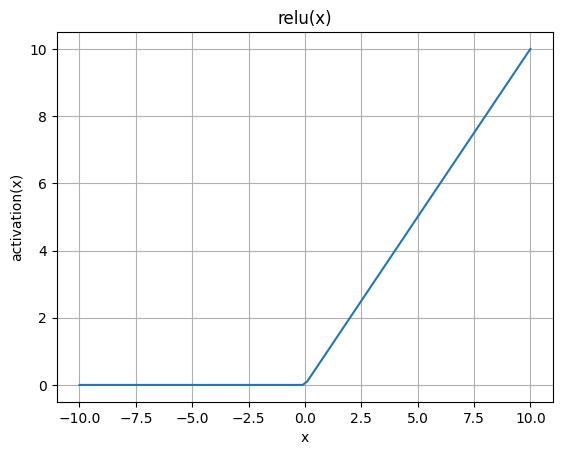

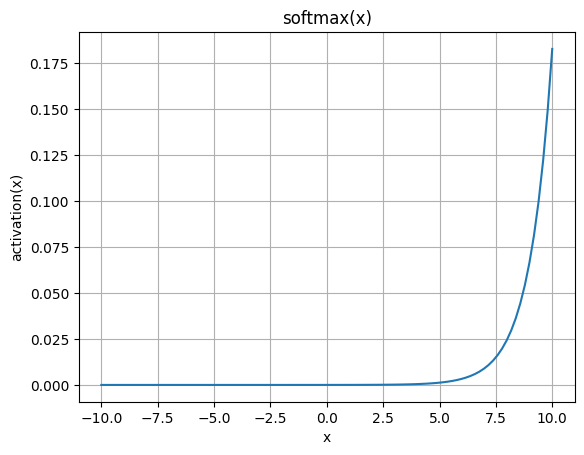

In [4]:
def plot_func(x,y, title):
    # helper function to plot activation functions
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('activation(x)')
    plt.grid(True)
    plt.show()

x = np.linspace(-10, 10, 100)
plot_func(x, relu(x), 'relu(x)')
plot_func(x, softmax(x), 'softmax(x)')

In [44]:
class NN:
    def __init__(self, layers_sizes):
        self.layer_sizes = layers_sizes
        self.num_layers = len(layers_sizes)
        self.weights = {f"W{i}": np.random.randn(layers_sizes[i - 1], layers_sizes[i]) for i in range(1, len(layers_sizes))}
        self.biases = {f"b{i}": np.random.randn(1, layers_sizes[i]) for i in range(1, len(layers_sizes))}
        self.cache = {}
        self.grads = {}
        self.costs = []

    # def cross_entropy_loss(self, AL, Y):
        
    #     epsilon=1e-8
    #     AL = np.clip(AL, epsilon, 1 - epsilon)
    #     cost = np.sum( - (np.dot(np.log(AL), Y.T) + np.dot(np.log(1 - AL), (1-Y).T)), axis=1)
    #     return cost
        
    def categorical_cross_entropy(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = - np.sum(y_true * np.log(y_pred)) / len(y_true)
        return loss
    
    def cross_entropy_back(self, AL, Y):
        epsilon=1e-8
        AL = np.clip(AL, epsilon, 1 - epsilon)
        dEdAL =  - (Y * np.divide(1, AL))
        return dEdAL
    

    def forward_pass(self, X):
        self.cache['A0'] = X
        for i in range(self.num_layers - 2):
            Z = np.dot(self.cache[f"A{i}"], self.weights[f"W{i + 1}"]) + self.biases[f"b{i + 1}"]
            self.cache[f"Z{i + 1}"] = Z
            A = relu(Z)
            self.cache[f"A{i + 1}"] = A


        Z = np.dot(self.cache[f"A{i + 1}"], self.weights[f"W{i + 2}"]) + self.biases[f"b{i + 2}"]
        self.cache[f"Z{i + 2}"] = Z
        A = softmax(Z)
        self.cache[f"A{i + 2}"] = A
        return A
    
    def linear_activation_backward(self, dEdA, current_layer, activation_function):

        if activation_function == "softmax":
            dAdZ = softmax_derivative(self.cache[f"A{current_layer}"])
            dEdA = self.grads[f'dEdA{current_layer}'].reshape(60000, 10, 1)
            dEdZ = np.sum(dAdZ * dEdA, axis=1)
        elif activation_function == "relu":
            dAdZ = relu_derivative(self.cache[f"Z{current_layer}"])
            dEdZ = np.multiply(dEdA, dAdZ)
        else:
            print(f"Error: function {activation_function} is not supported")

        # print(dEdZ)
        dW = (1 / dEdZ.shape[0] ) * np.dot(dEdZ.T, self.cache[f"A{current_layer - 1}"]).T
        db = (1 / dEdZ.shape[0] ) * np.sum(dEdZ, axis=0)
        dEdA_prev = np.dot(dEdZ, self.weights[f"W{current_layer}"].T)
        self.grads[f"dW{current_layer}"] = dW
        self.grads[f"db{current_layer}"] = db
        self.grads[f"dEdA{current_layer - 1}"] = dEdA_prev

    def backward_pass(self, AL, Y):
        cost = self.categorical_cross_entropy(y_pred=AL, y_true=Y)
        # average_cost = (1/cost.shape[0])*np.sum(cost)
        self.costs.append(cost)
        current_layer = self.num_layers - 1 # 3
        dEdAL = self.cross_entropy_back(AL, Y) 
        self.grads[f'dEdA{current_layer}'] = dEdAL
        # print(self.grads['D'])
        
        self.linear_activation_backward(dEdA=dEdAL, current_layer=current_layer, activation_function="softmax")
        for i in reversed(range(current_layer - 1)):
            current_layer = i + 1
            self.linear_activation_backward(dEdA=self.grads[f"dEdA{current_layer}"], current_layer=current_layer, activation_function="relu")
            # print(i)

    def update_params(self, learning_rate):
        for i in range(self.num_layers - 1):
            # print(self.weights['W1'][0])
            self.weights[f"W{i + 1}"] = self.weights[f"W{i + 1}"] - (learning_rate * self.grads[f"dW{i + 1}"])
            self.biases[f"b{i + 1}"] = self.biases[f"b{i + 1}"] - (learning_rate * self.grads[f"db{i + 1}"])

    def plot_cost_graph(self):
        x_value = list(range(1, len(self.costs) + 1))
        plt.xlabel('iteration')
        plt.ylabel('cost')
        plt.plot(x_value, self.costs, color='g')
        plt.show()

    def show_confusion_matrix(self, y_true, y_pred, classes):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def test(self, X_test, Y_test, matrix, metrics=[]):
        result = self.forward_pass(X_test)
        predictions = result.argmax(axis=1)
        expected = Y_test.argmax(axis=1)

        classes = np.unique(expected)

        if matrix:
            self.show_confusion_matrix(y_true=expected, y_pred=predictions, classes=classes)

        if "accuracy" in metrics:
            accuracy = accuracy_score(expected, predictions)
            print(f"Accuracy: {accuracy * 100:.2f}%")
        if "precision" in metrics:
            precision = precision_score(expected, predictions, average='macro')
            print(f"Precision: {precision * 100:.2f}%")
        if "recall" in metrics:
            recall = recall_score(expected, predictions, average='macro')
            print(f"Recall: {recall * 100:.2f}%")
        if "f1-score" in metrics:
            f1 = f1_score(expected, predictions, average='macro')
            print(f"F1-score: {f1 * 100:.2f}%")




        return result, Y_test

    def train(self, X, Y, batch=128, epochs=100, learning_rate=0.01):

        for i in range(1, epochs + 1):
            idx = np.random.randint(3, size=batch)
            
            AL = self.forward_pass(X)
            self.backward_pass(AL, Y)    
            self.update_params(learning_rate) 

            if i % 10 == 0:
                print(f"[epoch {i}]")
                if i == epochs:
                    self.test(X, Y, matrix=True, metrics=['accuracy', 'precision', 'recall','f1-score'])
                else:
                    self.test(X, Y, matrix=False, metrics=['accuracy'])
                print('cost:', self.costs[i-1])

        self.plot_cost_graph()
        print('trained...') 

    def predict(self, X_test):
        result = self.forward_pass(X_test)
        predictions = result.argmax(axis=0)
        return predictions

In [46]:
nn = NN([784, 128, 64, 10])
nn.train(train_data, train_label, epochs=1000, batch=1024, learning_rate=0.04)

[epoch 10]
Accuracy: 15.60%
cost: 28.98533710951597


In [38]:
a, b = nn.test(test_data, test_label, metrics=['accuracy'])

Accuracy: 41.37%


In [43]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)